## 1. 포화도 라벨링 기준 설정 및 라벨링
**경쟁강도 :: 상권 점포수 / 행정동 점포수** -> 이것만 사용하기로 결정  
매출경쟁도 :: 상권 당월 매출 / 해당 행정동 당월 매출  
상권밀집도 :: 상권 점포수 / 상권 면적

포화지수 = (경쟁강도 * 0.4) + (매출경쟁도 * 0.4) + (상권밀집도 * 0.2)

In [11]:
import pandas as pd
import numpy as np
from scipy import stats

# 1. 데이터 불러오기
# CSV 파일이 로컬에 있다면 파일 경로를 사용하세요.
# 예를 들어, 파일명이 "seoulsisanggweonbunseog_sample.csv"라고 가정합니다.
df = pd.read_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\피처엔지니어링일단다한통합데이터.csv")

# 경쟁강도 지수 계산
df['경쟁강도'] = df.groupby('상권_코드_명')['점포_수'].transform('sum') / df.groupby('행정동_코드_명')['점포_수'].transform('sum')


In [17]:
# 1. 단순 랜덤 샘플링
sample_size = 1000  # 원하는 샘플 크기
random_sample = df.sample(n=sample_size, random_state=42)

random_sample.to_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\종합_서울상권분석데이터.csv", index=False, encoding='utf-8-sig')

In [2]:
# 경쟁강도 컬럼의 평균 계산
mean_competition = df['경쟁강도'].mean()

# 새로운 컬럼 생성하여 라벨링
df['상권_상태'] = np.where(df['경쟁강도'] >= mean_competition, '포화', '여유')

### 가설검정

c:\Users\m\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 118621.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\m\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 326961.
  res = hypotest_fun_out(*samples, **kwds)


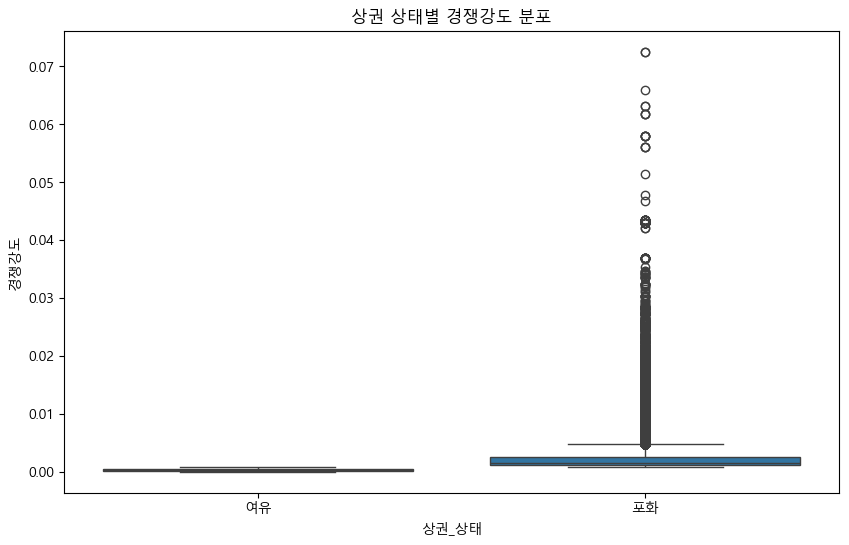


=== 검정 결과 ===
1. 정규성 검정 p-value (포화/여유): 2.5079421031239045e-164 / 2.9756342052250662e-120
2. 등분산성 검정 p-value: 0.0
3. Mann-Whitney U 검정 p-value: 0.0


In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 정규성 검정
saturated = df[df['상권_상태']=='포화']['경쟁강도']
unsaturated = df[df['상권_상태']=='여유']['경쟁강도']

stat_sat, p_sat = stats.shapiro(saturated)
stat_unsat, p_unsat = stats.shapiro(unsaturated)

# 2. 등분산성 검정
stat_lev, p_lev = stats.levene(saturated, unsaturated)

# 3. Mann-Whitney U test (비모수 검정)
stat_mw, p_mw = stats.mannwhitneyu(saturated, unsaturated)

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # 윈도우의 경우
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 시각화
plt.figure(figsize=(10,6))
sns.boxplot(x='상권_상태', y='경쟁강도', data=df)
plt.title('상권 상태별 경쟁강도 분포')
plt.show()

# 결과 출력
print("\n=== 검정 결과 ===")
print("1. 정규성 검정 p-value (포화/여유):", p_sat, "/", p_unsat)
print("2. 등분산성 검정 p-value:", p_lev)
print("3. Mann-Whitney U 검정 p-value:", p_mw)

### 비모수 검정


=== Mann-Whitney U 검정 결과 ===
통계량: 38784440781.0
p-value: 0.0

=== 기술통계량 ===
          count      mean       std       min       25%       50%       75%  \
상권_상태                                                                         
여유     326961.0  0.000330  0.000236  0.000000  0.000134  0.000283  0.000497   
포화     118621.0  0.002412  0.002641  0.000885  0.001142  0.001561  0.002584   

            max  
상권_상태            
여유     0.000884  
포화     0.072464  

=== 중위수 비교 ===
상권_상태
여유    0.000283
포화    0.001561
Name: 경쟁강도, dtype: float64


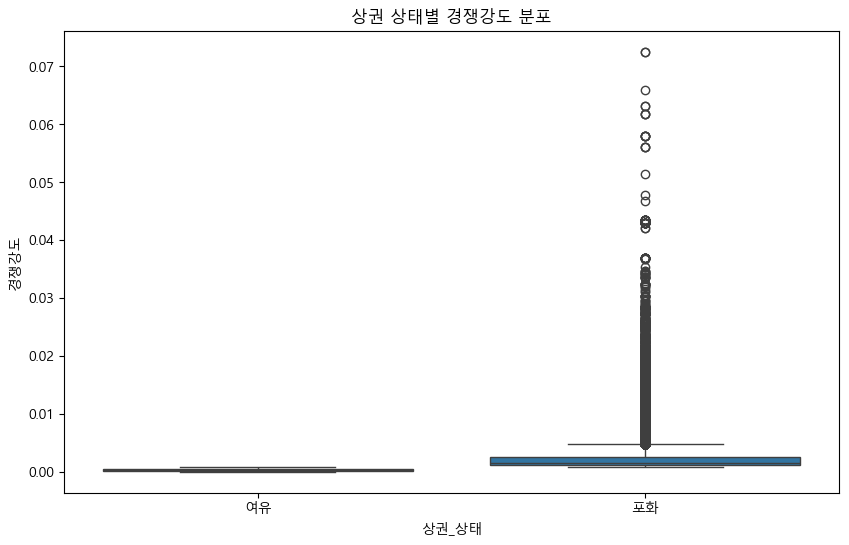

In [26]:
# 두 그룹으로 데이터 분리
saturated = df[df['상권_상태']=='포화']['경쟁강도']
unsaturated = df[df['상권_상태']=='여유']['경쟁강도']

# Mann-Whitney U 검정 수행
statistic, pvalue = stats.mannwhitneyu(saturated, unsaturated, 
                                     alternative='two-sided')

# 시각화
plt.figure(figsize=(10,6))
sns.boxplot(x='상권_상태', y='경쟁강도', data=df)
plt.title('상권 상태별 경쟁강도 분포')

# 기술통계량 계산
desc_stats = df.groupby('상권_상태')['경쟁강도'].describe()

# 결과 출력
print("\n=== Mann-Whitney U 검정 결과 ===")
print(f"통계량: {statistic}")
print(f"p-value: {pvalue}")

print("\n=== 기술통계량 ===")
print(desc_stats)

# 각 그룹의 중위수 출력
print("\n=== 중위수 비교 ===")
print(df.groupby('상권_상태')['경쟁강도'].median())

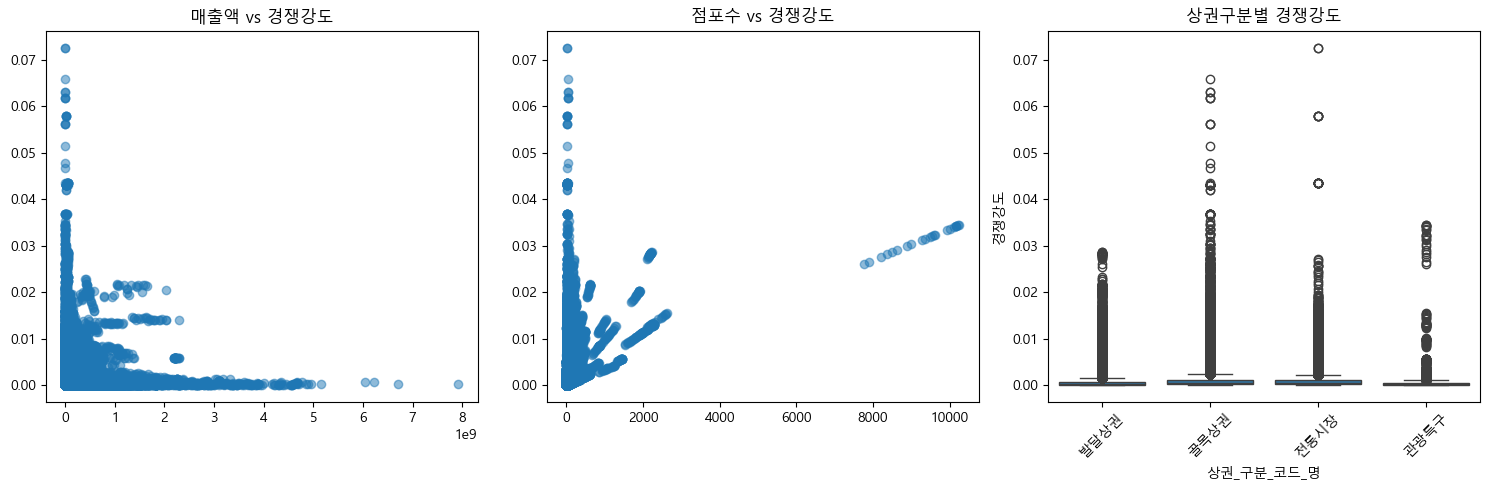


=== 분석 결과 ===
1. 매출액-경쟁강도 상관계수: -0.0779335387634301
   p-value: 0.0

2. 점포수-경쟁강도 상관계수: 0.5141708080242481
   p-value: 0.0

3. 상권구분별 경쟁강도 차이 검정
   Kruskal-Wallis H: 15372.38441021179
   p-value: 0.0


In [28]:
# 1. 매출액과 경쟁강도 상관관계 분석
correlation_sales = stats.spearmanr(df['당월_매출_금액'], df['경쟁강도'])

# 2. 점포수와 경쟁강도 상관관계 분석
correlation_stores = stats.spearmanr(df['점포_수'], df['경쟁강도'])

# 3. 상권 구분별 경쟁강도 차이 분석
kruskal_result = stats.kruskal(*[group['경쟁강도'].values 
                                for name, group in df.groupby('상권_구분_코드_명')])

# 시각화
plt.figure(figsize=(15,5))

# 1. 매출액-경쟁강도 산점도
plt.subplot(131)
plt.scatter(df['당월_매출_금액'], df['경쟁강도'], alpha=0.5)
plt.title('매출액 vs 경쟁강도')

# 2. 점포수-경쟁강도 산점도
plt.subplot(132)
plt.scatter(df['점포_수'], df['경쟁강도'], alpha=0.5)
plt.title('점포수 vs 경쟁강도')

# 3. 상권구분별 경쟁강도 박스플롯
plt.subplot(133)
sns.boxplot(x='상권_구분_코드_명', y='경쟁강도', data=df)
plt.xticks(rotation=45)
plt.title('상권구분별 경쟁강도')

plt.tight_layout()
plt.show()

# 결과 출력
print("\n=== 분석 결과 ===")
print("1. 매출액-경쟁강도 상관계수:", correlation_sales[0])
print("   p-value:", correlation_sales[1])
print("\n2. 점포수-경쟁강도 상관계수:", correlation_stores[0])
print("   p-value:", correlation_stores[1])
print("\n3. 상권구분별 경쟁강도 차이 검정")
print("   Kruskal-Wallis H:", kruskal_result[0])
print("   p-value:", kruskal_result[1])


분석 결과에 대해 다음과 같이 해석할 수 있습니다:

## 1. 매출액과 경쟁강도의 관계
- 상관계수: -0.078 (약한 음의 상관관계)
- p-value가 0.0으로 통계적으로 유의미함
- 경쟁강도가 높을수록 매출액이 오히려 약간 감소하는 경향을 보임
- 이는 과도한 경쟁이 개별 점포의 매출에 부정적 영향을 미칠 수 있음을 시사

## 2. 점포수와 경쟁강도의 관계
- 상관계수: 0.514 (중간 정도의 양의 상관관계)
- p-value가 0.0으로 통계적으로 유의미함
- 점포수가 많을수록 경쟁강도가 높아지는 뚜렷한 경향이 있음
- 이는 경쟁강도 지표가 실제 시장의 경쟁 상황을 잘 반영함을 보여줌

## 3. 상권 구분별 차이
- Kruskal-Wallis H 통계량: 15372.38
- p-value가 0.0으로 통계적으로 매우 유의미함
- 상권 구분(발달상권/골목상권/전통시장 등)에 따라 경쟁강도에 명확한 차이가 있음
- 이는 상권 유형별로 서로 다른 경쟁 환경이 형성되어 있음을 의미

## 종합 결론
1. 경쟁강도는 실제 시장 상황을 잘 반영하는 신뢰할 만한 지표임
2. 과도한 경쟁은 매출에 부정적 영향을 미칠 수 있음
3. 상권 유형별로 차별화된 경쟁 환경이 존재함

이러한 결과는 경쟁강도를 상권 분석의 중요한 지표로 활용할 수 있음을 보여줍니다.

In [34]:
# 상권_상태별 개수 계산
status_count = df['상권_상태'].value_counts()

# 결과 출력
print("\n=== 상권 상태별 개수 ===")
print(status_count)
print("\n=== 상권 상태별 비율(%) ===")
print(status_count / len(df) * 100)


=== 상권 상태별 개수 ===
상권_상태
여유    326961
포화    118621
Name: count, dtype: int64

=== 상권 상태별 비율(%) ===
상권_상태
여유    73.378413
포화    26.621587
Name: count, dtype: float64



=== 상관관계 검정 결과 ===
   variable  correlation  p_value
2      개업_율     0.151411      0.0
3      폐업_률     0.145758      0.0
4     영역_면적     0.095459      0.0
0  당월_매출_금액     0.077934      0.0
1  총_유동인구_수     0.062669      0.0

=== 상권 유형별 차이 검정 결과 ===
Kruskal-Wallis H 통계량: 15372.38441021179
p-value: 0.0


C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 44428 (\N{HANGUL SYLLABLE GWEON}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 44264 (\N{HANGUL SYLLABLE GOL}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\Local\Temp\ipykernel_19244\1103781944.py:50: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  plt.tight_layout()
C:\Users\m\AppData\

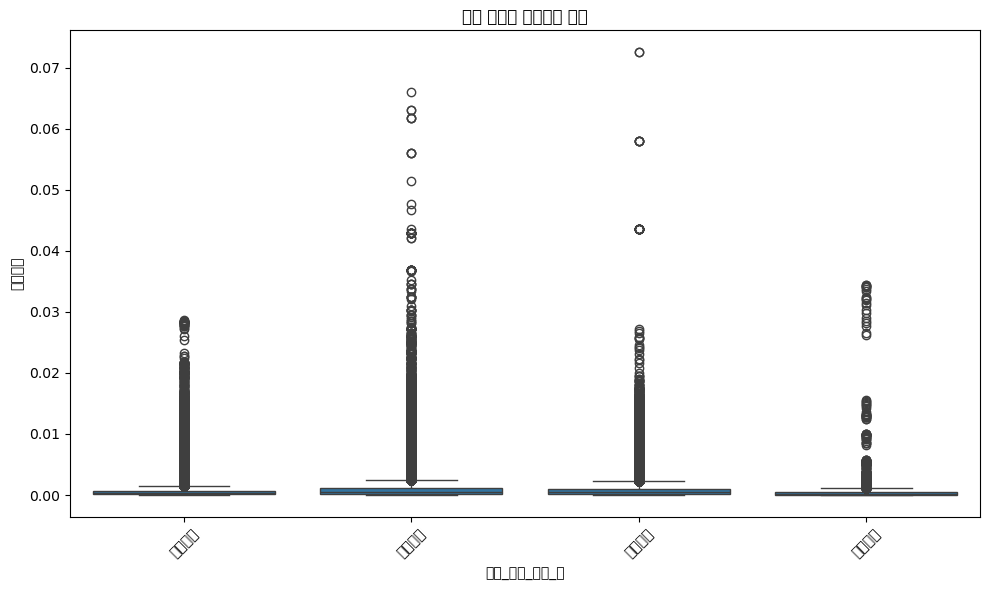

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 상관관계 분석 (Spearman 상관계수)
def correlation_test(df, target_vars):
    corr_results = []
    for var in target_vars:
        corr, p_value = stats.spearmanr(df[var], df['경쟁강도'])
        corr_results.append({
            'variable': var,
            'correlation': abs(corr),
            'p_value': p_value
        })
    return pd.DataFrame(corr_results)

# 2. 검정할 변수들
target_vars = [
    '당월_매출_금액',
    '총_유동인구_수',
    '개업_율',
    '폐업_률',
    '영역_면적'
]

# 3. 상권 유형별 차이 검정 (Kruskal-Wallis H test)
def type_difference_test(df):
    groups = [group['경쟁강도'].values for name, group in df.groupby('상권_구분_코드_명')]
    return stats.kruskal(*groups)

# 4. 검정 실행
correlation_results = correlation_test(df, target_vars)
type_test_stat, type_test_p = type_difference_test(df)

# 5. 결과 출력
print("\n=== 상관관계 검정 결과 ===")
print(correlation_results.sort_values('correlation', ascending=False))

print("\n=== 상권 유형별 차이 검정 결과 ===")
print(f"Kruskal-Wallis H 통계량: {type_test_stat}")
print(f"p-value: {type_test_p}")

# 6. 시각화
plt.figure(figsize=(10,6))
sns.boxplot(x='상권_구분_코드_명', y='경쟁강도', data=df)
plt.title('상권 유형별 경쟁강도 분포')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 파생변수 생성
def create_derived_variables(df):
    # 매출 관련 파생변수
    df['매출_점포비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['점포_수'].transform('sum')
    df['매출_면적비'] = df['당월_매출_금액'] / df['영역_면적']
    df['매출_유동인구비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['총_유동인구_수'].transform('sum')

    # 점포 관련 파생변수
    df['점포_밀도'] = df['점포_수'] / df['영역_면적']
    df['프랜차이즈_비율'] = df['프랜차이즈_점포_수'] / df['점포_수']
    
    # 유동인구 관련 파생변수
    df['유동인구_면적비'] = df['총_유동인구_수'] / df['영역_면적']
    
    return df

# 2. 상관관계 분석
def correlation_analysis(df, target_vars):
    corr_results = []
    for var in target_vars:
        corr, p_value = stats.spearmanr(df[var], df['경쟁강도'])
        corr_results.append({
            'variable': var,
            'correlation': abs(corr),
            'p_value': p_value
        })
    return pd.DataFrame(corr_results)

# 3. 검정 실행
derived_vars = [
    '매출_점포비',
    '매출_면적비',
    '매출_유동인구비',
    '점포_밀도',
    '프랜차이즈_비율',
    '유동인구_면적비'
]

df = create_derived_variables(df)
correlation_results = correlation_analysis(df, derived_vars)

# 4. 결과 출력
print("\n=== 파생변수 상관관계 검정 결과 ===")
print(correlation_results.sort_values('correlation', ascending=False))

# 5. 시각화
plt.figure(figsize=(10,6))
sns.boxplot(x='상권_구분_코드_명', y='점포_밀도', data=df)
plt.title('상권 구분별 점포 밀도 분포')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

# 포화도 종합

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\피처엔지니어링일단다한통합데이터.csv")

In [18]:
# 기준년분기코드 기준으로 전분분기 대비 점포수가 증가한 경우에 1/0 부여하기
df['전분기_점포수'] = df.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
df['점포수 증가'] = (df['유사_업종_점포_수'] > df['전분기_점포수']).astype(int)

# 20242 까지의 점수 합산
df['개업 점수'] = df.groupby('상권_코드_명')['점포수 증가'].cumsum()

In [19]:
df = df[df['기준_년분기_코드'] == 20242]
df['매출_점포비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['점포_수'].transform('sum')
df['매출_유동인구비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['총_유동인구_수'].transform('sum')

# 경쟁강도 지수 계산
df['경쟁강도'] = df.groupby('상권_코드_명')['점포_수'].transform('sum') / df.groupby('행정동_코드_명')['점포_수'].transform('sum')

df['프랜차이즈_비율'] = df.groupby('상권_코드_명')['프랜차이즈_점포_수'].transform('sum') / df.groupby('상권_코드_명')['점포_수'].transform('sum')
df = df.drop_duplicates()

In [20]:
pohado_df = df[['상권_코드_명','경쟁강도','매출_점포비','프랜차이즈_비율','개업 점수']]
# 중복 제거
pohado_df = pohado_df.drop_duplicates()

In [21]:
pohado_df = pohado_df.groupby('상권_코드_명')[['경쟁강도','매출_점포비','프랜차이즈_비율','개업 점수']].mean().reset_index()

### 데이터 표준화 및 PAC 수행

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# 분석에 사용할 변수 선택
features = ['매출_점포비', '프랜차이즈_비율', '개업 점수']

# inf 값을 NaN으로 변경
pohado_score_df = pohado_df.replace([np.inf, -np.inf], np.nan)

# 결측치를 각 컬럼의 평균값으로 대체
pohado_score_df[features] = pohado_score_df[features].fillna(pohado_score_df[features].mean())

# 데이터 표준화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(pohado_score_df[features])

# PCA 수행
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_scaled)

### 포화도 점수 부여

In [111]:
# 0~20으로 스케일링
mms = MinMaxScaler(feature_range=(0, 20))
saturation_score = mms.fit_transform(pca_result)

# 결과를 데이터프레임에 추가
pohado_df['포화도_점수'] = saturation_score

# 상권_코드_명과 포화도_점수만 선택
result = pohado_df[['상권_코드_명', '포화도_점수']]

# 포화도 점수 기준 내림차순 정렬
result = result.sort_values('포화도_점수', ascending=False)

In [104]:
result

,상권_코드_명,포화도_점수
959,신우어린이공원,20.000000
1114,영진시장A동,16.039766
1097,영등포시장역 3번,14.949552
1253,장위동성당,12.616505
50,강동성심병원,12.003732
...,...,...
291,노원역,0.484238
946,신사역,0.310279
25,가산디지털단지,0.172253
507,명동 남대문 북창동 다동 무교동 관광특구,0.132590


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1. 기본 통계량 확인
print("=== 포화도 점수 기초 통계량 ===")
print(result['포화도_점수'].describe())

# 2. 분포 시각화
plt.figure(figsize=(12,6))

# 히스토그램과 커널밀도추정
plt.subplot(121)
sns.histplot(data=result, x='포화도_점수', kde=True)
plt.title('포화도 점수 분포')
plt.xlabel('포화도 점수')
plt.ylabel('빈도')

# 박스플롯
plt.subplot(122)
sns.boxplot(y=result['포화도_점수'])
plt.title('포화도 점수 박스플롯')
plt.ylabel('포화도 점수')

plt.tight_layout()
plt.show()

# 3. 상권 구분별 포화도 점수 분포
plt.figure(figsize=(10,6))
sns.boxplot(x='상권_구분_코드_명', y='포화도_점수', data=result)
plt.title('상권 구분별 포화도 점수 분포')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 포화도점수 2차

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def calculate_opening_score(df):
    # 기준년분기코드 기준으로 전분기 대비 점포수 증가여부 확인
    df['전분기_점포수'] = df.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1)
    df['점포수 증가'] = (df['유사_업종_점포_수'] > df['전분기_점포수']).astype(int)
    
    # 누적 합산하여 개업 점수 계산
    df['개업 점수'] = df.groupby('상권_코드_명')['점포수 증가'].cumsum()
    return df

def preprocess_data(df):
    # 필요한 컬럼 선택
    features = ['개업 점수', '매출_점포비', '매출_유동인구비', '경쟁강도', '프랜차이즈_비율']
    
    # inf 값을 NaN으로 변경
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # 결측치를 각 컬럼의 평균값으로 대체
    df[features] = df[features].fillna(df[features].mean())
    
    return df

def calculate_saturation_score(df):
    features = ['개업 점수', '매출_점포비', '매출_유동인구비', '경쟁강도', '프랜차이즈_비율']
    
    # 표준화
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])
    
    # PCA 수행
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(scaled_features)
    
    # 0~20 스케일링
    mms = MinMaxScaler(feature_range=(0, 20))
    saturation_scores = mms.fit_transform(pca_result)
    
    return saturation_scores

def main():
    # 데이터 로드
    df = pd.read_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\피처엔지니어링일단다한통합데이터.csv")
    
    # 개업 점수 계산
    df = calculate_opening_score(df)
    
    # 상권별 지표 계산
    df['매출_점포비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / \
                    df.groupby('상권_코드_명')['점포_수'].transform('sum')
    
    df['매출_유동인구비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / \
                      df.groupby('상권_코드_명')['총_유동인구_수'].transform('sum')
    
    df['경쟁강도'] = df.groupby('상권_코드_명')['점포_수'].transform('sum') / \
                  df.groupby('행정동_코드_명')['점포_수'].transform('sum')
    
    df['프랜차이즈_비율'] = df.groupby('상권_코드_명')['프랜차이즈_점포_수'].transform('sum') / \
                      df.groupby('상권_코드_명')['점포_수'].transform('sum')
    
    # 중복 제거
    df = df.drop_duplicates(subset=['상권_코드_명'])
    
    # 데이터 전처리
    processed_df = preprocess_data(df)
    
    # 포화도 점수 계산
    scores = calculate_saturation_score(processed_df)
    
    # 결과 데이터프레임 생성
    result_df = pd.DataFrame({
        '상권_코드_명': processed_df['상권_코드_명'],
        '포화도_점수': scores.flatten()
    })
    
    # 포화도 점수 기준 내림차순 정렬
    result_df = result_df.sort_values('포화도_점수', ascending=False)
    
    return result_df

# 실행
if __name__ == "__main__":
    result = main()
    print(result)


            상권_코드_명     포화도_점수
41127         장위동성당  20.000000
5335      영등포시장역 3번  16.242067
2091      강서농산물도매시장  13.956894
416      노원 을지대학교병원  13.569535
1177         강동성심병원   9.387691
...             ...        ...
1763        신길동홍어거리   0.114268
711             구로역   0.105680
1027   동대문패션타운 관광특구   0.085614
9784         창신역 1번   0.028224
2897           구반포역   0.000000

[1521 rows x 2 columns]


#### 3차 포화도 점수 계산

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\피처엔지니어링일단다한통합데이터.csv")

# 기준년분기코드 기준으로 전분분기 대비 점포수가 증가한 경우에 1/0 부여하기
df['전분기_점포수'] = df.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
df['점포수 증가'] = (df['유사_업종_점포_수'] > df['전분기_점포수']).astype(int)

# 20242 까지의 점수 합산
df['개업 점수'] = df.groupby('상권_코드_명')['점포수 증가'].cumsum()

In [8]:
df = df[df['기준_년분기_코드'] == 20242]
df['매출_점포비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['점포_수'].transform('sum')
df['매출_유동인구비'] = df.groupby('상권_코드_명')['당월_매출_금액'].transform('sum') / df.groupby('상권_코드_명')['총_유동인구_수'].transform('sum')

# 경쟁강도 지수 계산
df['경쟁강도'] = df.groupby('상권_코드_명')['점포_수'].transform('sum') / df.groupby('행정동_코드_명')['점포_수'].transform('sum')

df['프랜차이즈_비율'] = df.groupby('상권_코드_명')['프랜차이즈_점포_수'].transform('sum') / df.groupby('상권_코드_명')['점포_수'].transform('sum')
df = df.drop_duplicates()

In [9]:
pohado_df = df[['상권_코드_명','경쟁강도','매출_점포비','프랜차이즈_비율','개업 점수']]
# 중복 제거
pohado_df = pohado_df.drop_duplicates()

In [10]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby('상권_코드_명')[features].mean().reset_index()

# 데이터 정규화 및 PCA 수행
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA

# 로그 변환
for feature in features:
    if df_selected[feature].min() < 0:
        df_selected[feature] = df_selected[feature] - df_selected[feature].min() + 1
    df_selected[feature] = np.log1p(df_selected[feature])

# 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# 정규분포로 변환
qt = QuantileTransformer(output_distribution='normal')
normalized_features = qt.fit_transform(scaled_features)

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(normalized_features)

# 균일 분포로 변환 후 0~20 스케일링
qt_uniform = QuantileTransformer()
final_scores = qt_uniform.fit_transform(pca_result) * 20

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': final_scores.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)


              상권_코드_명     포화도_점수
939          신림현대종합상가  20.000000
363   도곡2동주민센터(대치중학교)  19.987295
1282             조양시장  19.970002
893        시흥3동 우편취급국  19.960009
226             금천파출소  19.949593
...               ...        ...
195              구파발역   0.058694
1271         정릉3동주민센터   0.039836
390        독산역 1번 출입구   0.024437
618               봉원사   0.019854
1253            장위동성당   0.000000

[1502 rows x 2 columns]


In [12]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby('상권_코드_명')[features].mean().reset_index()

# 데이터 정규화 및 PCA 수행
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
import numpy as np

# 로그 변환
for feature in features:
    if df_selected[feature].min() < 0:
        df_selected[feature] = df_selected[feature] - df_selected[feature].min() + 1
    df_selected[feature] = np.log1p(df_selected[feature])

# 정규화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_features)

# 정규분포로 변환 (평균 10, 표준편차 3으로 설정)
from scipy import stats
final_scores = stats.norm.cdf(pca_result) * 20  # 0~1 사이 값을 0~20으로 스케일링

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': final_scores.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)


                           상권_코드_명        포화도_점수
1253                         장위동성당  2.000000e+01
1114                        영진시장A동  2.000000e+01
1414             한국교통안전공단 강남자동차검사소  2.000000e+01
1097                     영등포시장역 3번  2.000000e+01
959                        신우어린이공원  2.000000e+01
...                            ...           ...
599                          백석중학교  6.973695e-03
410                   동대문패션타운 관광특구  1.608816e-03
1394  평화시장(남평화시장, 제일평화시장, 신평화패션타운)  1.144404e-03
88                           경기대학교  1.042963e-03
1368                         청평화시장  7.894001e-07

[1502 rows x 2 columns]


In [27]:
result_df.to_csv(r"C:\Users\m\project\공공데이터_상권분석\data\머신러닝\상권별 포화도 점수.csv", index=False, encoding='utf-8-sig')

In [26]:
import numpy as np

# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")

주성분 1: 설명된 분산 비율 = 0.6361


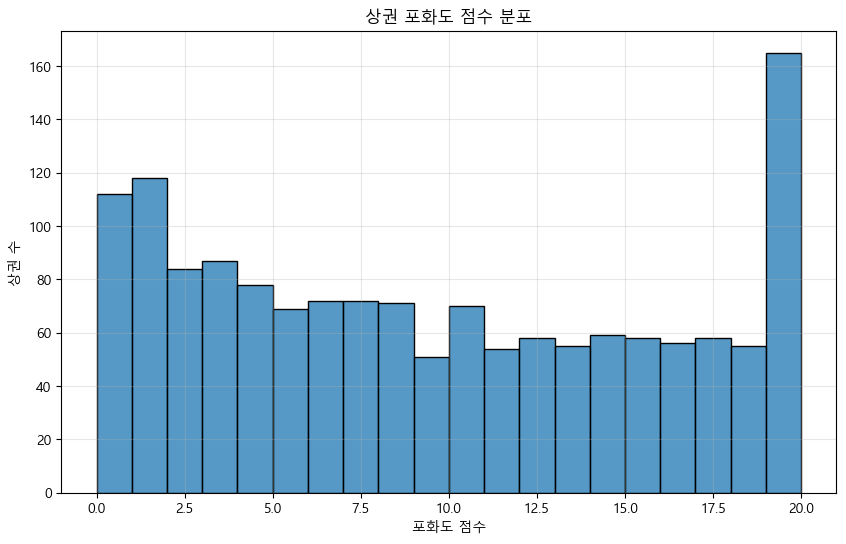

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

# 히스토그램 생성
plt.figure(figsize=(10, 6))
sns.histplot(data=result_df, x='포화도_점수', bins=20)

# 그래프 제목과 축 레이블 설정
plt.title('상권 포화도 점수 분포')
plt.xlabel('포화도 점수')
plt.ylabel('상권 수')

# 그리드 추가
plt.grid(True, alpha=0.3)

plt.show()
